# General Assembly DSI - Capstone Project

#### Chenhao (Andy) Xu, June 13, 2022

## * Data Source

https://www.kaggle.com/datasets/abeperez/historical-plane-crash-data

## * Problem Statement

As an airplane fan, it is both my personal and public attention about the air travel safety. Although air travel is one of the safest transportation nowadays, the risk still exist, especially the high injury and mortality rate when single accident occurred. In order to help publics to understand more about the plane crashes, this study utilizes the features of aircraft type and age, operator, flight phase, crash site and time in the historical airplane crash records and explores the severeness of crash, whether there is survivor or not. 

## * Library Import

In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from imblearn.over_sampling import RandomOverSampler

## * Load the Data

In [2]:
df_crash = pd.read_csv('data/crash_data_1918.csv', encoding= 'unicode_escape')

## 1. Data Cleaning

### 1.1. General Cleaning

In [3]:
# Shape of original dataset
df_crash.shape

(28440, 24)

In [4]:
df_crash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28440 entries, 0 to 28439
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              28440 non-null  object 
 1   Time              13894 non-null  object 
 2   Aircraft          28439 non-null  object 
 3   Operator          28440 non-null  object 
 4   Registration      27627 non-null  object 
 5   Flight phase      27801 non-null  object 
 6   Flight type       28383 non-null  object 
 7   Survivors         27136 non-null  object 
 8   Crash site        28058 non-null  object 
 9   Schedule          19481 non-null  object 
 10  MSN               24269 non-null  object 
 11  YOM               23119 non-null  float64
 12  Flight no.        2838 non-null   object 
 13  Crash location    28427 non-null  object 
 14  Country           28439 non-null  object 
 15  Region            28439 non-null  object 
 16  Crew on board     28416 non-null  float6

In [5]:
df_crash.head(2)

,Date,Time,Aircraft,Operator,Registration,Flight phase,Flight type,Survivors,Crash site,Schedule,...,Country,Region,Crew on board,Crew fatalities,Pax on board,PAX fatalities,Other fatalities,Total fatalities,Circumstances,Crash cause
0,1918-05-02,NaN,De Havilland DH.4,United States Signal Corps - USSC,AS-32084,Takeoff (climb),Test,No,Airport (less than 10 km from airport),Dayton - Dayton,...,United States of America,North America,2.0,2.0,0.0,0.0,0.0,2,The single engine airplane departed Dayton-McC...,Technical failure
1,1918-06-08,NaN,Handley Page V/1500,Handley Page Aircraft Company Ltd,E4104,Takeoff (climb),Test,Yes,Airport (less than 10 km from airport),Cricklewood - Cricklewood,...,United Kingdom,Europe,6.0,5.0,0.0,0.0,0.0,5,"Assembled at Cricklewood Airfield in May 1918,...",Technical failure


In [6]:
# null values in original dataset
df_crash.isnull().sum()

Date                    0
Time                14546
Aircraft                1
Operator                0
Registration          813
Flight phase          639
Flight type            57
Survivors            1304
Crash site            382
Schedule             8959
MSN                  4171
YOM                  5321
Flight no.          25602
Crash location         13
Country                 1
Region                  1
Crew on board          24
Crew fatalities         1
Pax on board           54
PAX fatalities          1
Other fatalities       10
Total fatalities        0
Circumstances          25
Crash cause             0
dtype: int64

In [8]:
# Convert the date into datetime series
df_crash['Date'] = pd.to_datetime(df_crash['Date'])

In [9]:
# Calculate the aircraft age at the time of crash
df_crash['aircraft_age'] = df_crash['Date'].dt.year - df_crash['YOM']

In [10]:
# Found something does not make sense. There was 1924 people on board of a airplane...
df_crash['Crew on board'].max()

# Remove this row
df_crash = df_crash[df_crash['Crew on board'] != 1924.0]

Calculate the total souls on board and the total deaths on board. 
The Total fatalities includes the deaths on ground (Other fatalities) which is not part of the study. 

In [11]:
df_crash['people_on_board'] = df_crash['Crew on board'] + df_crash['Pax on board']
df_crash['fatal_on_board'] = df_crash['Crew fatalities'] + df_crash['PAX fatalities']

In [12]:
# Calcualte the number of survivors
df_crash['num_survivor'] = df_crash['people_on_board'] - df_crash['fatal_on_board']

In [13]:
# remove the rows that have more total deaths than total on board. 
df_crash = df_crash[df_crash['num_survivor'] >= 0]

In [14]:
# Remove columns that are either with too many missing values or not part of the study
df_crash = df_crash.drop(columns = ['Registration', 'Schedule', 'MSN', 'Flight no.', 'YOM', 'Crew on board', 'Crew fatalities', 'Pax on board', 'PAX fatalities', 
                                    'Other fatalities', 'Total fatalities'])

### 1.2. Convert y Value into numeric

In [15]:
# Convert whether there's survivor column to numeric. 
def survivors(word):
    if word == 'Yes':
        return 1
    elif word == 'No':
        return 0
    
df_crash['Survivors'] = df_crash['Survivors'].apply(survivors)

In [16]:
# Drop Nan for Survivors 
df_crash = df_crash.dropna(subset = ['Survivors'])

# reset index
df_crash = df_crash.reset_index(drop = True)

### 1.3. Detailed Data Cleaning

Data in the people on board and number of deaths are not always matching the answer in whether there's survivor. If Survivors are correct, the data in people on board and number of death may not accurate. In this study, we assume the column of whether there's survivor is correct

In [19]:
# For example: 
df_crash[df_crash['people_on_board'] == 0].tail(2)

,Date,Time,Aircraft,Operator,Flight phase,Flight type,Survivors,Crash site,Crash location,Country,Region,Circumstances,Crash cause,aircraft_age,people_on_board,fatal_on_board,num_survivor
26998,2022-02-24,NaN,Antonov AN-26,Russian Air Force - Voyenno-vozdushnye sily Ro...,Flight,Military,0.0,"Plain, Valley",Ostrogozhsk Voronezh oblast,Russia,Asia,The aircraft crashed in unknown circumstances ...,Unknown,43.0,0.0,0.0,0.0
27007,2022-04-03,NaN,Piper PA-31-350 Navajo Chieftain,Private Brazilian,Landing (descent or approach),Illegal (smuggling),1.0,"Plain, Valley",Cobán Alta Verapaz,Guatemala,Central America,Crashed in unknown circumstances in bushes nea...,Human factor,NaN,0.0,0.0,0.0


Fix the missing value in Country and Region. By reading the other features, it's been recognized that the location was US.

In [20]:
df_crash[df_crash['Country'].isna()]

,Date,Time,Aircraft,Operator,Flight phase,Flight type,Survivors,Crash site,Crash location,Country,Region,Circumstances,Crash cause,aircraft_age,people_on_board,fatal_on_board,num_survivor
6097,1945-02-01,NaN,Consolidated PBY-5A Catalina,United States Navy - USN,Flight,Survey / Patrol / Reconnaissance,0.0,"Lake, Sea, Ocean, River",NaN,NaN,NaN,Crashed in unknown circumstances into the sea ...,Unknown,NaN,10.0,10.0,0.0


In [21]:
# Fill up the null value for Country and Region
df_crash['Country'] = df_crash['Country'].replace(np.nan, 'United States of America')
df_crash['Region'] = df_crash['Region'].replace(np.nan, 'North America')

In [22]:
df_crash[df_crash['Country'] == 'World'] 
# Notice some crashes had country of 'World'. Since country is one feature of the model, we removed all crashes with country of world. 
# That's 582 crashes, compare to total 27020 crashes, it's not a big loss of data
df_crash = df_crash[df_crash['Country'] != 'World']

Reduce the number of columns(features) for later analysis: 

1. Flight type
2. Aircraf type

In [24]:
# Examing the type of the Flight type
df_crash['Flight type'].value_counts().head()

Scheduled Revenue Flight    5571
Military                    3944
Training                    3139
Cargo                       2755
Private                     2198
Name: Flight type, dtype: int64

There are too many flight type. We will reduce the number of types based on https://skybrary.aero/articles/type-flight

In [25]:
def flight_type(word):
    if word == 'Scheduled Revenue Flight': return 'Commercial'
    elif word == 'Military': return 'Military'
    elif word == 'Cargo': return 'Commercial'
    elif word == 'Charter/Taxi (Non Scheduled Revenue Flight)': return 'Commercial'
    elif word == 'Executive/Corporate/Business': return 'Commercial'
    elif word == 'Bombing': return 'Military'
    elif word == 'Government': return 'Commercial'
    else: return 'General Aviation'

In [26]:
df_crash['Flight type'] = df_crash['Flight type'].apply(flight_type)

In [27]:
# Final three types of flights
df_crash['Flight type'].value_counts()

Commercial          11354
General Aviation    10516
Military             4568
Name: Flight type, dtype: int64

In [28]:
# Examing the type of the aircrafts
df_crash['Aircraft'].value_counts().head()

Douglas C-47 Skytrain (DC-3)    1988
PZL-Mielec AN-2                  681
Curtiss C-46 Commando            554
Avro 652 Anson                   496
De Havilland DH.60 Moth          416
Name: Aircraft, dtype: int64

In [29]:
Aircraft_type = pd.DataFrame(df_crash['Aircraft'])

In [30]:
# Mannual combine some type of aircraft
atrs = ['ATR42-200', 'ATR42-300', 'ATR42-500', 'ATR42-600', 'ATR2-200', 'ATR72-500', 'ATR72-600']
final_atr = ['ATR ATR42-200', 'ATR ATR42-300', 'ATR ATR42-500', 'ATR ATR42-600', 'ATR ATR2-200', 'ATR ATR72-500', 'ATR ATR72-600']

Aircraft_type['Aircraft'] = Aircraft_type['Aircraft'].replace(atrs, final_atr)

In [31]:
# Deal with case issue for the same manufacturer
Aircraft_type['Aircraft'] = Aircraft_type['Aircraft'].replace('Bae', 'BAe')

In [32]:
manufacturer = []
for item in Aircraft_type['Aircraft']:
    manufacturer.append(item.split(' ')[0])

manufacturer = pd.DataFrame(manufacturer, columns = ['manufacturer'])

In [34]:
# the only manufacturer with two words are De Havilland. Mannually fix. 
manufacturer = manufacturer.replace('De', 'De Havilland')

In [35]:
# number of types of aircraft manufacturer. 
len(manufacturer['manufacturer'].value_counts())

244

In [36]:
df_crash['manufacturer'] = manufacturer['manufacturer']

Major Datasets: 

1. df_crash (26438 rows): The dataset includes all crash records.
2. df_comm (11354 rows):  The dataset only includes the crashes of commercial flights.
3. df_jet (8936 rows):   The dataset only includes the crashes of commercial flights in jet age (after 1952). 
4. df_time (13566 rows):  The dataset only includes the crashes with the records of crash time HH:MM. 

In [38]:
df_crash.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26438 entries, 0 to 27019
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             26438 non-null  datetime64[ns]
 1   Time             13566 non-null  object        
 2   Aircraft         26438 non-null  object        
 3   Operator         26438 non-null  object        
 4   Flight phase     26211 non-null  object        
 5   Flight type      26438 non-null  object        
 6   Survivors        26438 non-null  float64       
 7   Crash site       26340 non-null  object        
 8   Crash location   26426 non-null  object        
 9   Country          26438 non-null  object        
 10  Region           26438 non-null  object        
 11  Circumstances    26435 non-null  object        
 12  Crash cause      26438 non-null  object        
 13  aircraft_age     21785 non-null  float64       
 14  people_on_board  26438 non-null  float

In [39]:
df_crash.shape

(26438, 18)

In [40]:
df_comm = df_crash[df_crash['Flight type'] == 'Commercial']
df_comm = df_comm.reset_index(drop = True)

df_comm.shape

In [42]:
# In commercial aviation the jet age was introduced to Britain in 1952 with the first scheduled flight of the de Havilland Comet airliner 
df_jet = df_crash[df_crash['Date'].dt.year >=1953]
df_jet = df_jet[df_jet['Flight type'] == 'Commercial']
df_jet = df_jet.reset_index(drop = True)

df_jet.shape

In [44]:
df_time = df_crash.dropna(subset = ['Time'])
df_time = df_time.reset_index(drop = True)

df_time.shape

In [46]:
df_crash.to_csv('data/all_crash_data.csv', index = False)
df_comm.to_csv('data/comm_crash_data.csv', index = False)
df_jet.to_csv('data/jet_crash_data.csv', index = False)
df_time.to_csv('data/time_crash_data.csv', index = False)

In [300]:
df_time.corr()

,Survivors,aircraft_age,people_on_board,fatal_on_board,num_survivor,crash_time
Survivors,1.000000,0.008400,0.112743,-0.160642,0.285466,-0.007553
aircraft_age,0.008400,1.000000,-0.020690,-0.013108,-0.015621,-0.008455
people_on_board,0.112743,-0.020690,1.000000,0.641496,0.749831,0.018763
fatal_on_board,-0.160642,-0.013108,0.641496,1.000000,-0.026540,0.004177
num_survivor,0.285466,-0.015621,0.749831,-0.026540,1.000000,0.020847
crash_time,-0.007553,-0.008455,0.018763,0.004177,0.020847,1.000000


In common sense, we may guess the crash time (the time of the crash during a day) is related to the severness of the crash. 
However, the correlation shows the there's no relation between them. 

## 2. EDA

In [47]:
df_crash.head(2)

,Date,Time,Aircraft,Operator,Flight phase,Flight type,Survivors,Crash site,Crash location,Country,Region,Circumstances,Crash cause,aircraft_age,people_on_board,fatal_on_board,num_survivor,manufacturer
0,1918-05-02,NaN,De Havilland DH.4,United States Signal Corps - USSC,Takeoff (climb),General Aviation,0.0,Airport (less than 10 km from airport),Dayton-McCook Field Ohio,United States of America,North America,The single engine airplane departed Dayton-McC...,Technical failure,NaN,2.0,2.0,0.0,De Havilland
1,1918-06-08,NaN,Handley Page V/1500,Handley Page Aircraft Company Ltd,Takeoff (climb),General Aviation,1.0,Airport (less than 10 km from airport),Cricklewood London Metropolis,United Kingdom,Europe,"Assembled at Cricklewood Airfield in May 1918,...",Technical failure,0.0,6.0,5.0,1.0,Handley


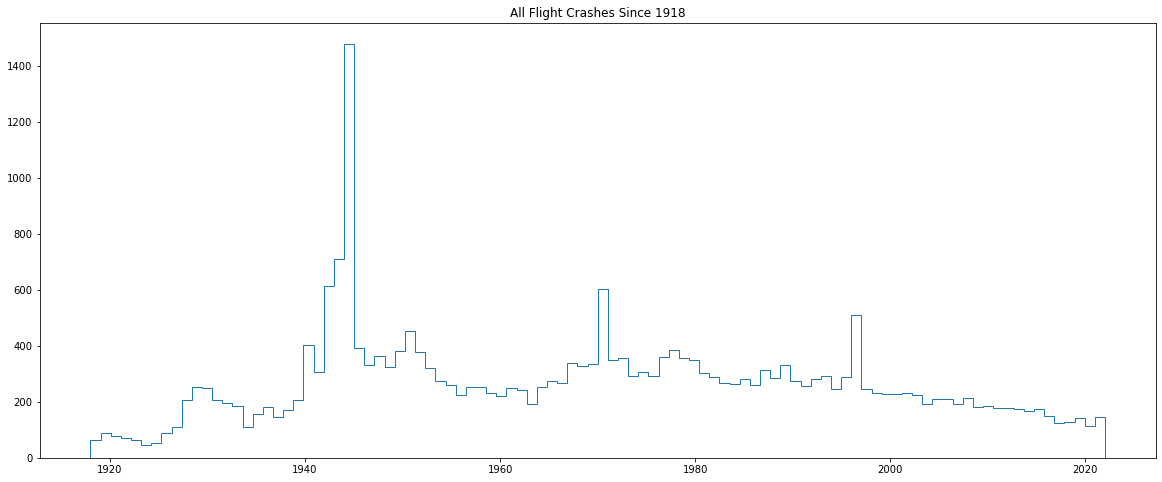

In [50]:
plt.figure(figsize=(20, 8))
plt.hist(df_crash['Date'].dt.year, bins = 100, histtype = 'step')
plt.title('All Flight Crashes Since 1918');
plt.savefig('image/All_crash.jpg')

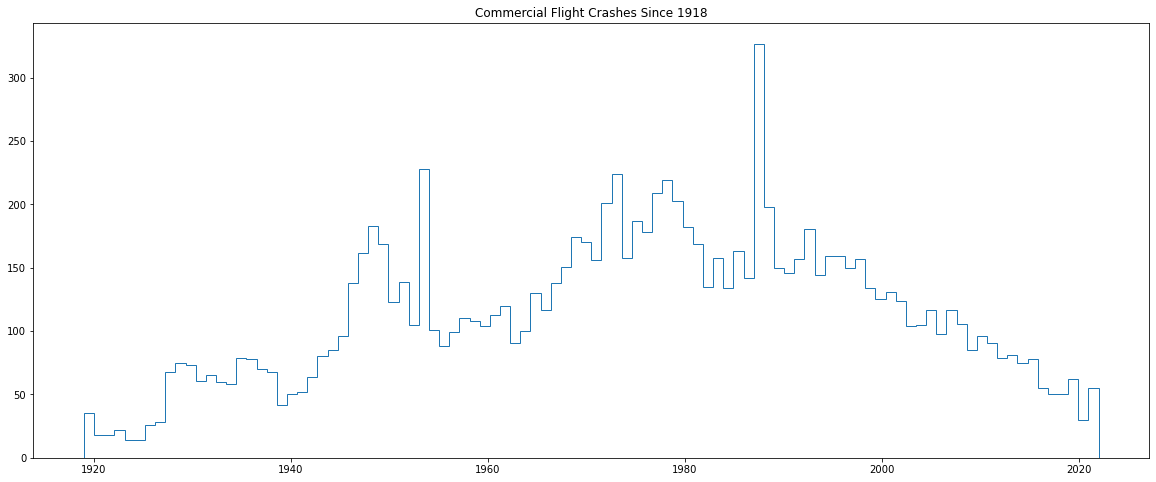

In [51]:
plt.figure(figsize=(20, 8))
plt.hist(df_comm['Date'].dt.year, bins = 100, histtype = 'step');
plt.title('Commercial Flight Crashes Since 1918');
plt.savefig('image/commercial_crash.jpg')

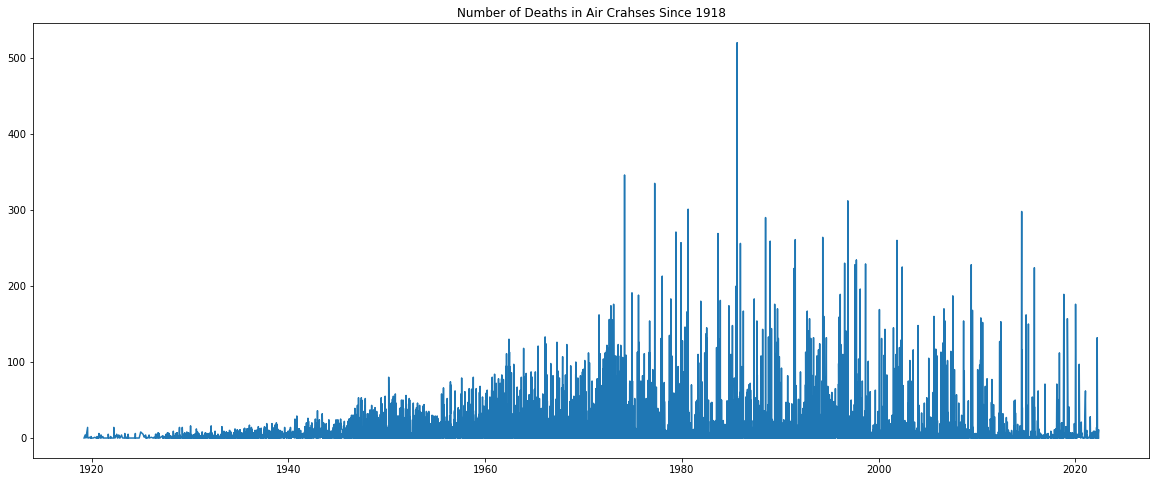

In [52]:
plt.figure(figsize=(20, 8))
plt.plot(df_comm['Date'], df_comm['fatal_on_board'])
plt.title('Number of Deaths in Air Crahses Since 1918');
plt.savefig('image/Number_deaths.jpg')

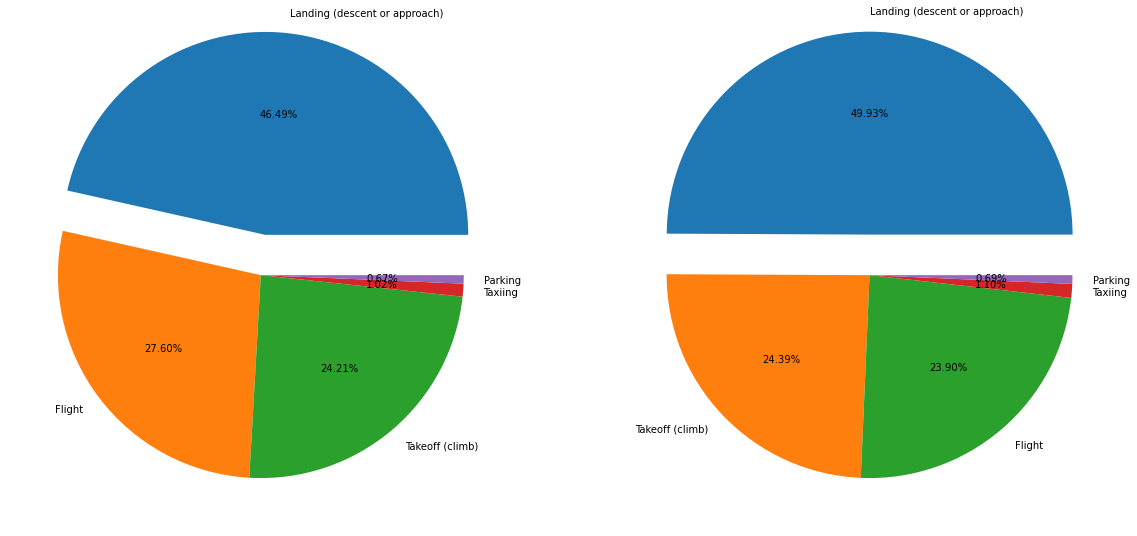

In [53]:
flight_phase2 = pd.DataFrame(df_jet['Flight phase'].value_counts())
flight_phase1 = pd.DataFrame(df_comm['Flight phase'].value_counts())

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.pie(flight_phase1['Flight phase'], labels = flight_phase1.index, explode = [0.2, 0, 0, 0, 0], autopct = '%1.2f%%')
# plt.title('Crashes by flight phase');

plt.subplot(1, 2, 2)
plt.pie(flight_phase2['Flight phase'], labels = flight_phase2.index, explode = [0.2, 0, 0, 0, 0], autopct = '%1.2f%%')
# plt.title('Crashes by flight phase');
plt.savefig('image/Commercial_Jet_crash_flight_phase.jpg')

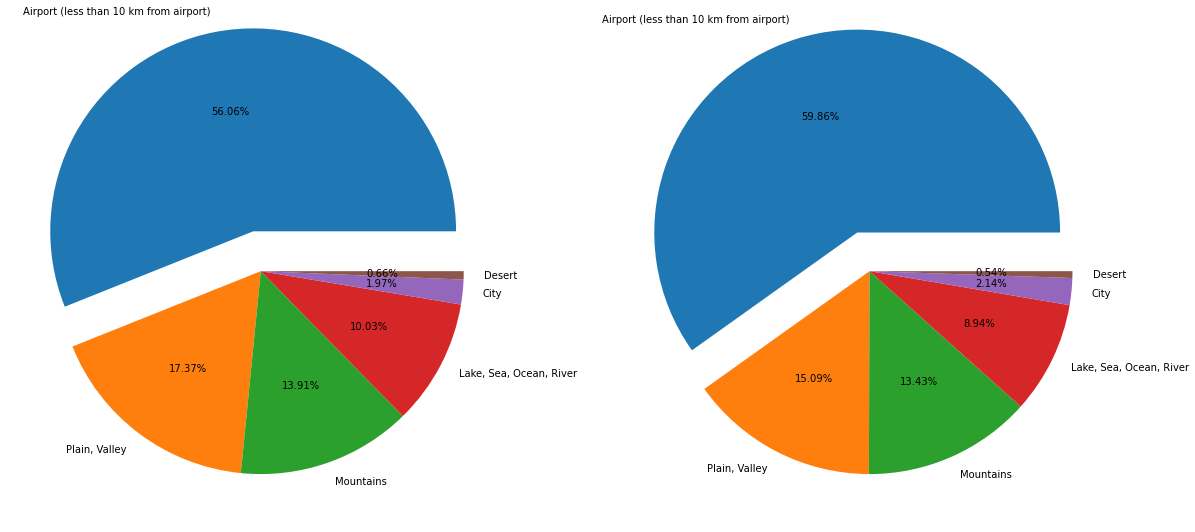

In [54]:
crash_location1 = pd.DataFrame(df_comm['Crash site'].value_counts())
crash_location2 = pd.DataFrame(df_jet['Crash site'].value_counts())

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.pie(crash_location1['Crash site'], labels = crash_location1.index, explode = [0.2, 0, 0, 0, 0, 0], autopct = '%1.2f%%')
# plt.title('Crashes by crash location')

plt.subplot(1, 2, 2)
plt.pie(crash_location2['Crash site'], labels = crash_location2.index, explode = [0.2, 0, 0, 0, 0, 0], autopct = '%1.2f%%')
# plt.title('Crashes by crash location');
plt.savefig('image/Commercial_Jet_crash_location.jpg')

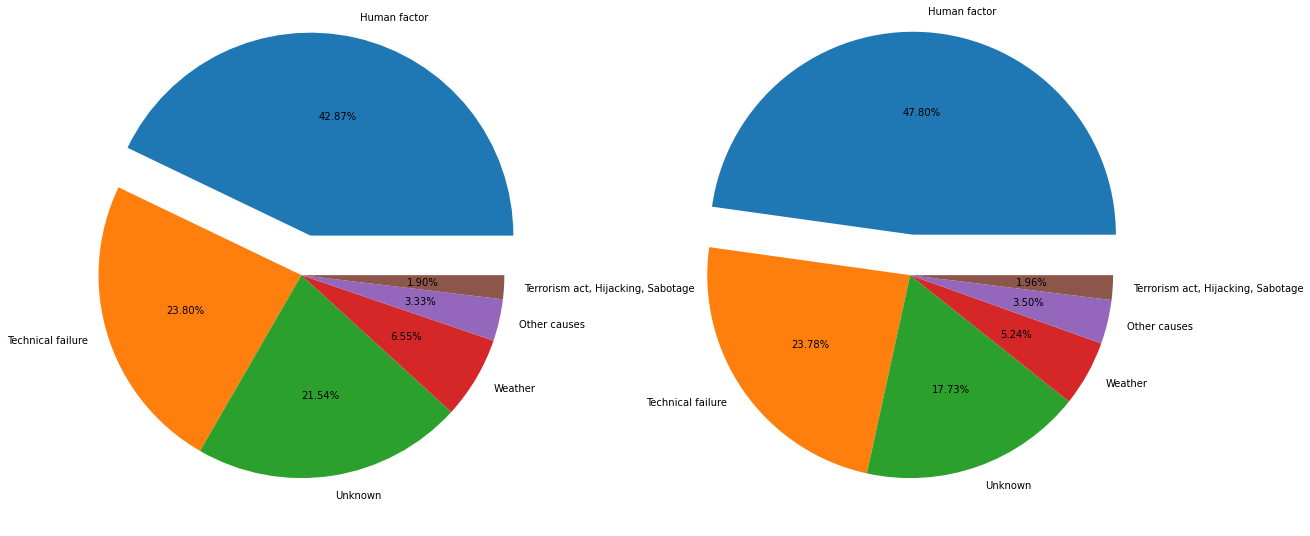

In [55]:
crash_cause1 = pd.DataFrame(df_comm['Crash cause'].value_counts())
crash_cause2 = pd.DataFrame(df_jet['Crash cause'].value_counts())

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.pie(crash_cause1['Crash cause'], labels = crash_cause1.index, explode = [0.2, 0, 0, 0, 0, 0], autopct = '%1.2f%%')
# plt.title('Crashes by crash cause')

plt.subplot(1, 2, 2)
plt.pie(crash_cause2['Crash cause'], labels = crash_cause2.index, explode = [0.2, 0, 0, 0, 0, 0], autopct = '%1.2f%%')
# plt.title('Crashes by crash cause');
plt.savefig('image/Commercial_Jet_crash_cause.jpg')

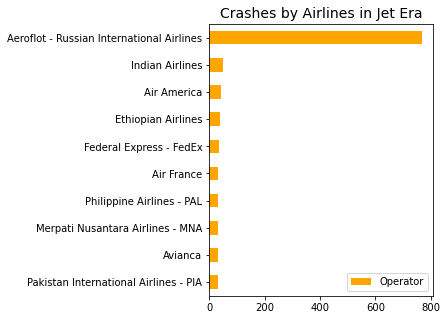

In [269]:
pd.DataFrame(df_jet['Operator'].value_counts()).head(10).plot(kind = 'barh', figsize = (4, 5), fontsize = 10, color = 'orange').invert_yaxis()
plt.title('Crashes by Airlines in Jet Era', fontsize = 14);
plt.savefig('image/Jet_crash_Airlines.jpg')

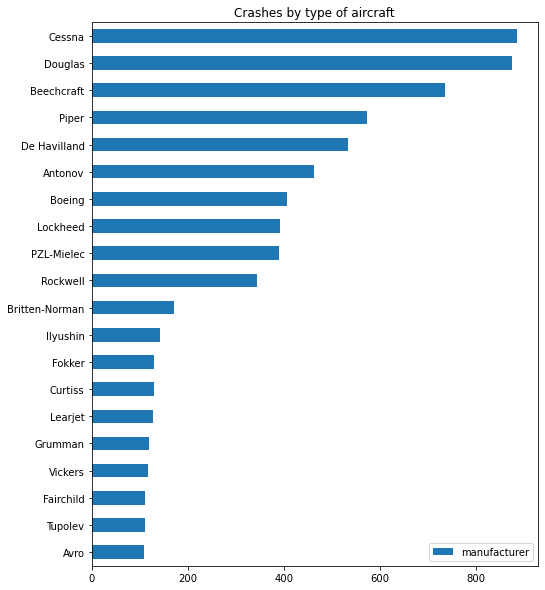

In [57]:
aircraft = pd.DataFrame(df_jet['manufacturer'].value_counts()).head(20).plot(kind = 'barh', figsize = (8, 10)).invert_yaxis()
plt.title('Crashes by type of aircraft');
plt.savefig('image/Jet_crash_manufacturer.jpg')

figure of the crash frequencies during a day

In [58]:
time_crash = []
for time in df_time['Time']:
    hour = time.split('H')[0]
    if len(hour) > 2:
        hour = '0'
    hour = int(hour)
    time_crash.append(hour)

time_crash = pd.DataFrame(time_crash, columns = ['Crash Time'])

In [59]:
df_time['crash_time'] = time_crash['Crash Time']

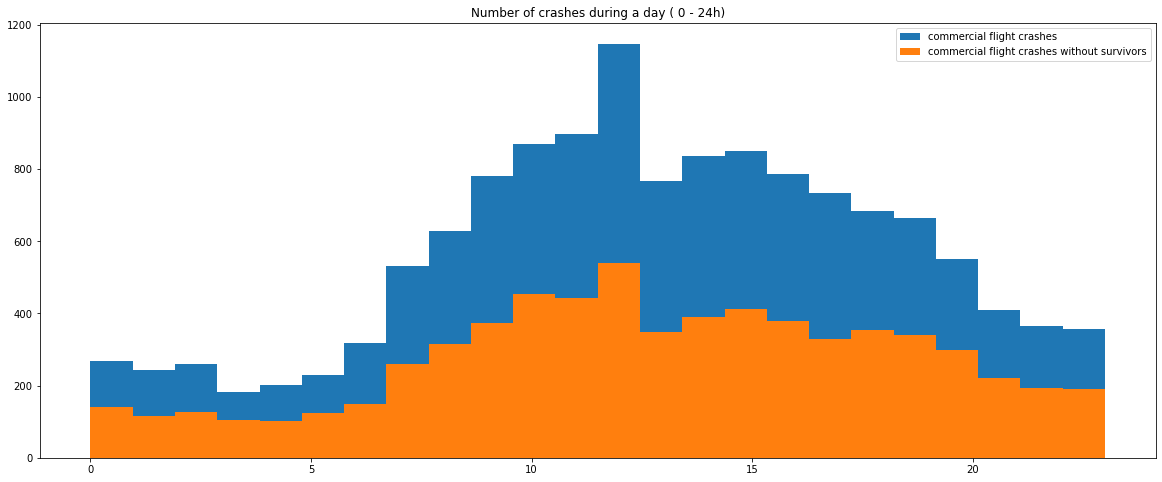

In [127]:
plt.figure(figsize=(20, 8))
plt.hist(time_crash['Crash Time'], bins = 24, label='commercial flight crashes')
plt.hist(df_time[df_time['Survivors'] == 0]['crash_time'], bins = 24, label='commercial flight crashes without survivors')
plt.title('Number of crashes during a day ( 0 - 24h)')
plt.legend();
plt.savefig('image/time_crash_24h.jpg')

## 3. Model

### 3.1. Study of df_crash Dataset

In [61]:
crash = df_crash

# Only keep the year of the crashes
crash['Year'] = crash['Date'].dt.year

In [190]:
df_crash['Crash cause'].value_counts()

Human factor                          9750
Unknown                               7501
Technical failure                     5906
Weather                               1502
Terrorism act, Hijacking, Sabotage    1169
Other causes                           610
Name: Crash cause, dtype: int64

In [62]:
crash = crash.drop(columns = ['Date', 'Time', 'Aircraft', 'Crash location', 'Region', 'Circumstances', 
                                 'people_on_board', 'fatal_on_board', 'num_survivor' ])

In [63]:
crash.isna().sum()

Operator           0
Flight phase     227
Flight type        0
Survivors          0
Crash site        98
Country            0
Crash cause        0
aircraft_age    4653
manufacturer     574
Year               0
dtype: int64

In [64]:
crash.shape

(26438, 10)

In [65]:
X = crash.drop(columns = ['Survivors'])
y = crash['Survivors']

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [67]:
X_train.shape, X_test.shape

((19828, 9), (6610, 9))

#### Baseline Model

In [68]:
y.value_counts(normalize = True)

1.0    0.574325
0.0    0.425675
Name: Survivors, dtype: float64

In [69]:
si = SimpleImputer(strategy = 'most_frequent')

In [70]:
si.fit(X_train)
X_train_fill = si.transform(X_train)
X_train_fill = pd.DataFrame(X_train_fill, columns = X_train.columns)

In [71]:
X_test_fill = si.transform(X_test)
X_test_fill = pd.DataFrame(X_test_fill, columns = si.feature_names_in_)

In [72]:
X_train_fill.isna().sum().sum(), X_test_fill.isna().sum().sum()

(0, 0)

In [73]:
ohe = OneHotEncoder(drop = 'if_binary', handle_unknown = 'ignore', sparse = False)

In [74]:
encoder = make_column_transformer(
    (ohe, ['Operator', 'Flight phase', 'Flight type', 'Crash site', 'Crash cause', 'Country', 'manufacturer']),
    remainder = 'passthrough',
    verbose_feature_names_out = False
)

In [75]:
X_train_enc = encoder.fit_transform(X_train_fill)
X_train_enc = pd.DataFrame(X_train_enc, columns = encoder.get_feature_names_out())

In [76]:
X_test_enc = encoder.transform(X_test_fill)
X_test_enc = pd.DataFrame(X_test_enc, columns = encoder.get_feature_names_out())

/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [77]:
X_train_enc.shape, X_test_enc.shape

((19828, 7485), (6610, 7485))

In [78]:
ss = StandardScaler()

In [79]:
X_train_ss = ss.fit_transform(X_train_enc)
X_train_ss = pd.DataFrame(X_train_ss, columns = ss.get_feature_names_out())

In [80]:
X_test_ss = ss.transform(X_test_enc)
X_test_ss = pd.DataFrame(X_test_ss, columns = ss.get_feature_names_out())

In [81]:
X_train_ss.shape, X_test_ss.shape

((19828, 7485), (6610, 7485))

In [82]:
log = LogisticRegression(max_iter = 10000)

In [83]:
log.fit(X_train_ss, y_train)

LogisticRegression(max_iter=10000)

In [84]:
log.score(X_train_ss, y_train), log.score(X_test_ss, y_test)

(0.8200020173492032, 0.6579425113464448)

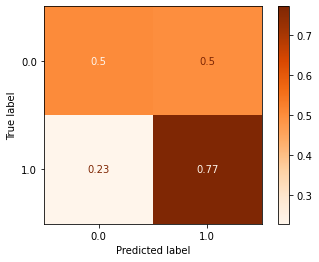

In [86]:
ConfusionMatrixDisplay.from_estimator(log, X_test_ss, y_test, normalize = 'true', cmap = 'Oranges');

In [87]:
coef = pd.DataFrame(list(zip(log.feature_names_in_, log.coef_[0])))
coef.columns = ['parameter', 'coefficient']

In [88]:
coef.sort_values(by = 'coefficient').head(10)

,parameter,coefficient
7028,Crash site_Mountains,-0.418659
7068,Country_Cameroon,-0.292537
7198,Country_Saint Vincent and Grenadines,-0.229846
7310,manufacturer_Comp,-0.224546
7413,manufacturer_PAC,-0.222122
7016,Flight phase_Flight,-0.192310
7196,Country_Saint Lucia,-0.181561
7030,Crash cause_Human factor,-0.173628
7481,manufacturer_Xian,-0.160891
6110,Operator_Tahiti Conquest Airlines,-0.157223


In [89]:
coef.sort_values(by = 'coefficient').tail(10)

,parameter,coefficient
7018,Flight phase_Parking,0.179359
7236,Country_US Virgin Islands,0.182002
7020,Flight phase_Taxiing,0.184362
5095,Operator_Québecair,0.192596
1540,Operator_Cameroon Airlines,0.203005
7017,Flight phase_Landing (descent or approach),0.209367
7104,Country_French Polynesia,0.276281
7130,Country_Jamaica,0.302144
7032,Crash cause_Technical failure,0.309554
7024,Crash site_Airport (less than 10 km from airport),0.350581


### 3.2. Study of df_comm Dataset

In [90]:
comm = df_comm
comm['Year'] = comm['Date'].dt.year
comm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11354 entries, 0 to 11353
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             11354 non-null  datetime64[ns]
 1   Time             6944 non-null   object        
 2   Aircraft         11354 non-null  object        
 3   Operator         11354 non-null  object        
 4   Flight phase     11225 non-null  object        
 5   Flight type      11354 non-null  object        
 6   Survivors        11354 non-null  float64       
 7   Crash site       11324 non-null  object        
 8   Crash location   11349 non-null  object        
 9   Country          11354 non-null  object        
 10  Region           11354 non-null  object        
 11  Circumstances    11353 non-null  object        
 12  Crash cause      11354 non-null  object        
 13  aircraft_age     10764 non-null  float64       
 14  people_on_board  11354 non-null  float

In [189]:
df_comm['Crash cause'].value_counts()

Human factor                          4868
Technical failure                     2702
Unknown                               2446
Weather                                744
Other causes                           378
Terrorism act, Hijacking, Sabotage     216
Name: Crash cause, dtype: int64

In [91]:
comm = comm.drop(columns = ['Date', 'Time', 'Aircraft', 'Crash location', 'Region', 'Circumstances', 
                                 'Flight type', 'people_on_board', 'fatal_on_board', 'num_survivor' ])

In [92]:
comm.isna().sum()

Operator          0
Flight phase    129
Survivors         0
Crash site       30
Country           0
Crash cause       0
aircraft_age    590
manufacturer    218
Year              0
dtype: int64

In [93]:
comm.shape

(11354, 9)

In [94]:
X = comm.drop(columns = ['Survivors'])
y = comm['Survivors']

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [96]:
y.value_counts(normalize = True)

1.0    0.636868
0.0    0.363132
Name: Survivors, dtype: float64

In [97]:
si = SimpleImputer(strategy = 'most_frequent')

In [98]:
si.fit(X_train)
X_train_fill = si.transform(X_train)
X_train_fill = pd.DataFrame(X_train_fill, columns = X_train.columns)

X_test_fill = si.transform(X_test)
X_test_fill = pd.DataFrame(X_test_fill, columns = si.feature_names_in_)

In [99]:
ohe = OneHotEncoder(drop = 'if_binary', handle_unknown = 'ignore', sparse = False)

In [100]:
encoder = make_column_transformer(
    (ohe, ['Operator', 'Flight phase', 'Crash site', 'Crash cause', 'Country', 'manufacturer']),
    remainder = 'passthrough',
    verbose_feature_names_out = False
)

In [101]:
X_train_enc = encoder.fit_transform(X_train_fill)
X_train_enc = pd.DataFrame(X_train_enc, columns = encoder.get_feature_names_out())

X_test_enc = encoder.transform(X_test_fill)
X_test_enc = pd.DataFrame(X_test_enc, columns = encoder.get_feature_names_out())

/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0, 4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


#### 3.2.1. Logistic Regression

In [102]:
pipe1 = make_pipeline(StandardScaler(), LogisticRegression(max_iter = 10000))

In [103]:
pipe1.fit(X_train_enc, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=10000))])

In [104]:
pipe1.score(X_train_enc, y_train), pipe1.score(X_test_enc, y_test)

(0.8881972988843218, 0.6671363156040859)

In [105]:
cross_val_score(pipe1, X_train_enc, y_train).mean(), cross_val_score(pipe1, X_test_enc, y_test).mean()

(0.6490898414562538, 0.652350522890429)

In [144]:
precision_score(y_train, pipe1.predict(X_train_enc)), precision_score(y_test, pipe1.predict(X_test_enc))

(0.8961545277334751, 0.7021077283372366)

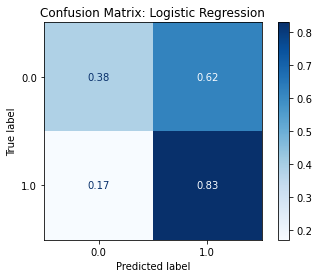

In [213]:
Log = ConfusionMatrixDisplay.from_estimator(pipe1, X_test_enc, y_test, normalize = 'true', cmap = 'Blues')
Log
plt.title('Confusion Matrix: Logistic Regression');

In [215]:
Log.figure_.savefig('image/log_confusion.jpg', dpi = 100)

In [256]:
pipe1.named_steps['logisticregression'].coef_
coef = pd.DataFrame(list(zip(pipe1.feature_names_in_, pipe1.named_steps['logisticregression'].coef_[0])))
coef.columns = ['parameter', 'coefficient']

In [257]:
coef.sort_values(by = 'coefficient').head(10)

,parameter,coefficient
4071,Crash site_Mountains,-0.629955
4257,Country_Tanzania,-0.427009
4109,Country_Cameroon,-0.400900
4392,manufacturer_Lioré-et-Olivier,-0.334814
4118,Country_Congo,-0.318148
1165,Operator_Compagnie Franco-Roumaine de Navigati...,-0.303562
3858,Operator_Vector Sky Service,-0.283350
1779,Operator_Helmut Horten,-0.273821
4276,Country_Venezuela,-0.271059
4087,Country_Australia,-0.257502


In [258]:
coef.sort_values(by = 'coefficient').tail(10)

,parameter,coefficient
4301,manufacturer_BAc,0.283624
4405,manufacturer_Morane-Saulnier,0.291639
4168,Country_Jamaica,0.304487
4064,Flight phase_Parking,0.311760
4150,Country_Greenland,0.328840
4144,Country_Gabon,0.345670
4375,manufacturer_IAI,0.418246
4123,Country_Czech Republic,0.456116
4067,Crash site_Airport (less than 10 km from airport),0.557569
4088,Country_Austria,0.816735


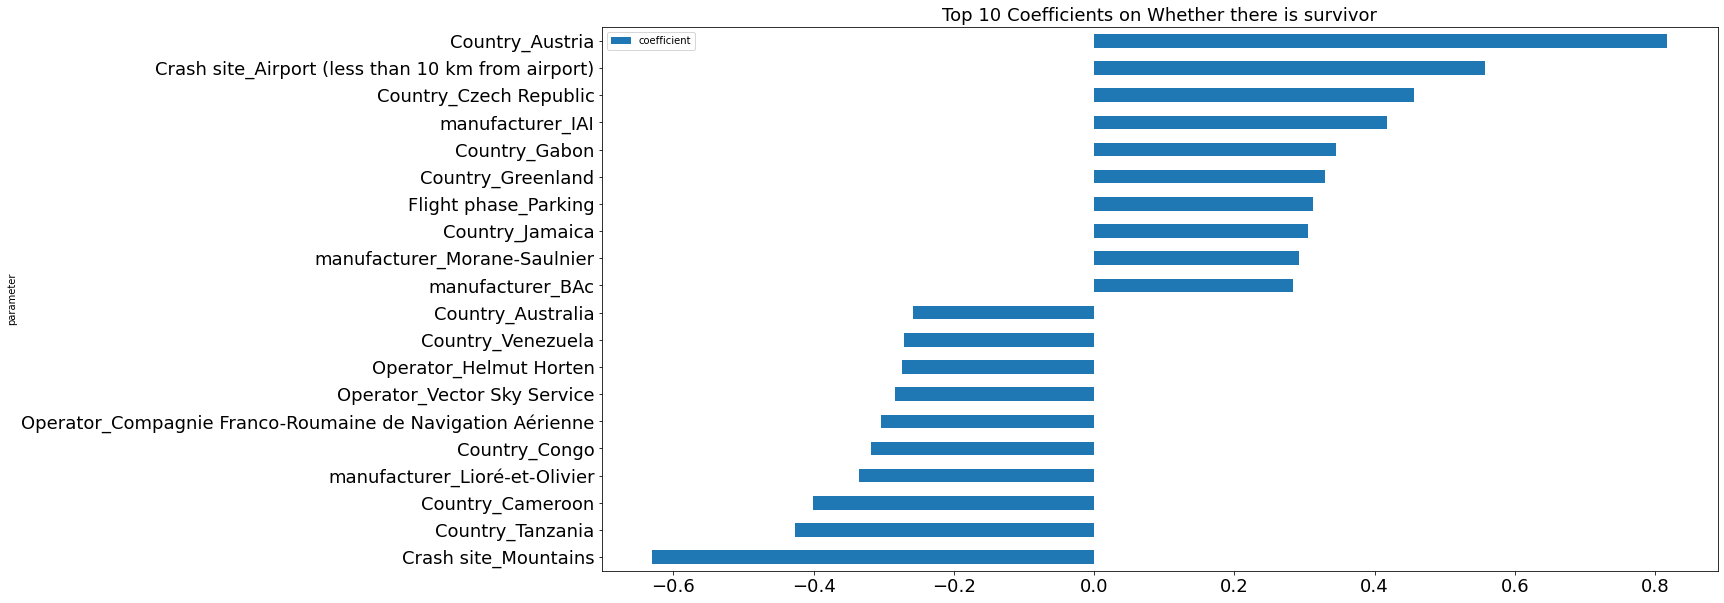

In [259]:
pd.concat([coef.sort_values(by = 'coefficient').head(10), coef.sort_values(by = 'coefficient').tail(10)]).set_index('parameter').plot(kind = 'barh', figsize = (20, 10), fontsize = 18);
plt.title('Top 10 Coefficients on Whether there is survivor', fontsize = 18);
plt.savefig('image/Logistic_top_10.jpg')

In [106]:
pipe1.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'logisticregression', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticregression__multi_class', 'logisticregression__n_jobs', 'logisticregression__penalty', 'logisticregression__random_state', 'logisticregression__solver', 'logisticregression__tol', 'logisticregression__verbose', 'logisticregression__warm_start'])

In [109]:
param_grid1 = {
    'logisticregression__C': [0.1, 0.5, 1.0], 
    'logisticregression__class_weight': ['balanced']
             }

gs1 = GridSearchCV(pipe1, param_grid = param_grid1, n_jobs = -1)

In [110]:
gs1.fit(X_train_enc, y_train)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.1, 0.5, 1.0],
                         'logisticregression__class_weight': ['balanced']})

In [111]:
gs1.best_params_

{'logisticregression__C': 0.1, 'logisticregression__class_weight': 'balanced'}

In [112]:
gs1.score(X_train_enc, y_train), gs1.score(X_test_enc, y_test)

(0.8823253082795067, 0.6653751320887636)

In [113]:
cross_val_score(gs1.best_estimator_, X_test_enc, y_test).mean()

0.6364948952977121

In [145]:
precision_score(y_train, gs1.predict(X_train_enc)), precision_score(y_test, gs1.predict(X_test_enc))

(0.9306448470679914, 0.7232049947970863)

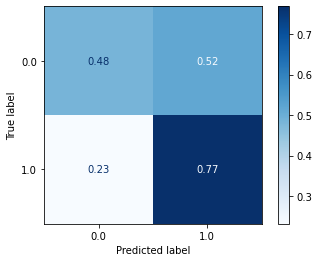

In [146]:
ConfusionMatrixDisplay.from_estimator(gs1, X_test_enc, y_test, normalize = 'true', cmap = 'Blues');

#### 3.2.2. KNN

In [149]:
pipe2 = make_pipeline(StandardScaler(), KNeighborsClassifier())

In [150]:
pipe2.fit(X_train_enc, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [151]:
pipe2.score(X_train_enc, y_train), pipe2.score(X_test_enc, y_test)

(0.7343511450381679, 0.6340260655160268)

In [152]:
cross_val_score(pipe2, X_train_enc, y_train).mean(), cross_val_score(pipe2, X_test_enc, y_test).mean()

(0.6321785085143864, 0.6023200933999057)

In [153]:
precision_score(y_train, pipe2.predict(X_train_enc)), precision_score(y_test, pipe2.predict(X_test_enc))

(0.7321874540913765, 0.6648092584654951)

In [154]:
pipe2.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])

In [155]:
param_grid2 = {
    'kneighborsclassifier__n_neighbors': [5, 10, 20], 
    'kneighborsclassifier__weights': ['uniform', 'distance'], 
             }
gs2 = GridSearchCV(pipe2, param_grid = param_grid2, n_jobs = -1)

In [156]:
gs2.fit(X_train_enc, y_train)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__n_neighbors': [5, 10, 20],
                         'kneighborsclassifier__weights': ['uniform',
                                                           'distance']})

In [157]:
gs2.best_params_

{'kneighborsclassifier__n_neighbors': 20,
 'kneighborsclassifier__weights': 'uniform'}

In [158]:
gs2.score(X_train_enc, y_train), gs2.score(X_test_enc, y_test)

(0.6737522019964768, 0.65797816132441)

In [159]:
cross_val_score(gs2.best_estimator_, X_test_enc, y_test).mean()

0.6445903817969545

In [160]:
precision_score(y_train, gs2.predict(X_train_enc)), precision_score(y_test, gs2.predict(X_test_enc))

(0.6729436380279848, 0.6632852126414358)

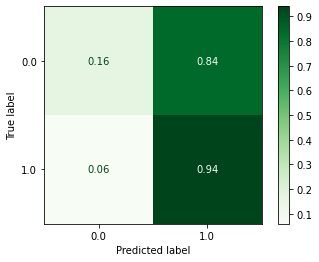

In [297]:
ConfusionMatrixDisplay.from_estimator(gs2, X_test_enc, y_test, normalize = 'true', cmap = 'Greens');

#### 3.3.3. Random Forest

In [169]:
pipe3 = make_pipeline(StandardScaler(), RandomForestClassifier())

In [170]:
pipe3.fit(X_train_enc, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier', RandomForestClassifier())])

In [171]:
pipe3.score(X_train_enc, y_train), pipe3.score(X_test_enc, y_test)

(0.9994128009395185, 0.7340612891863332)

In [172]:
cross_val_score(pipe3, X_train_enc, y_train).mean(), cross_val_score(pipe3, X_test_enc, y_test).mean()

(0.731650029359953, 0.7270133144546291)

In [173]:
precision_score(y_train, pipe3.predict(X_train_enc)), precision_score(y_test, pipe3.predict(X_test_enc))

(0.9992628086988573, 0.7429626211352099)

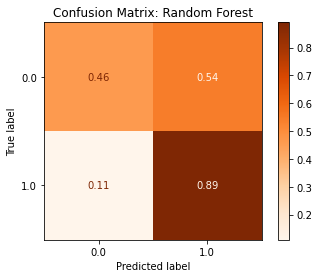

In [231]:
rfc = ConfusionMatrixDisplay.from_estimator(pipe3, X_test_enc, y_test, normalize = 'true', cmap = 'Oranges');
rfc
plt.title('Confusion Matrix: Random Forest');

In [232]:
rfc.figure_.savefig('image/rfc_confusion.jpg', dpi = 100)

In [302]:
coef = pd.DataFrame(pipe3.named_steps['randomforestclassifier'].feature_importances_, index = X_train_enc.columns, columns = ['coefficient'])

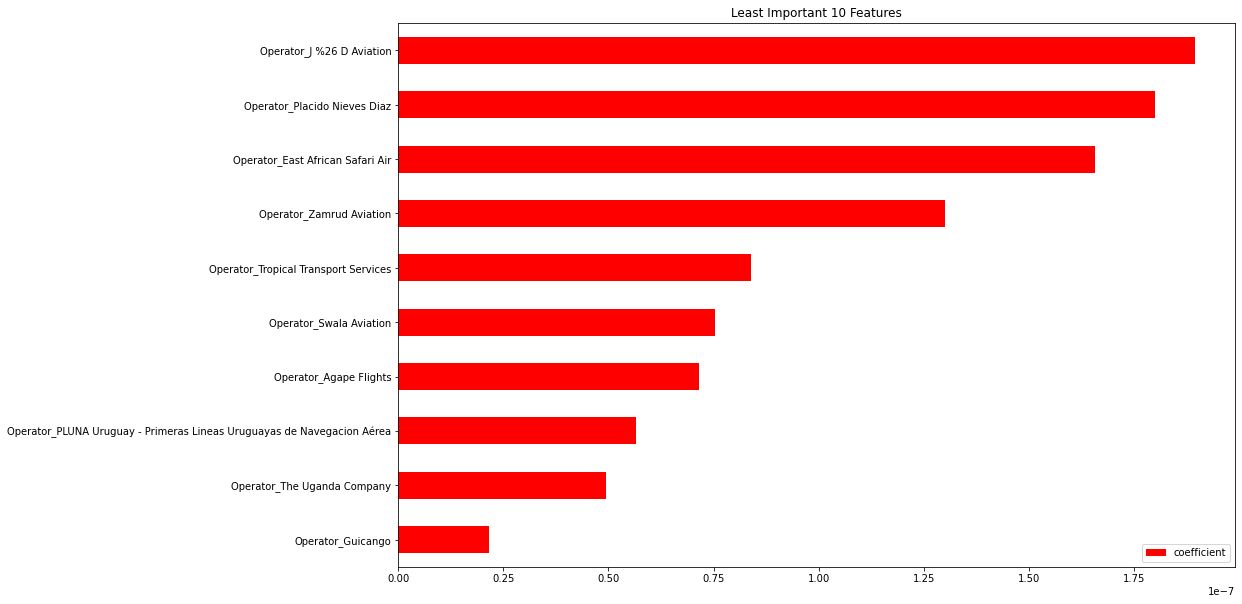

In [303]:
coef.sort_values(by = 'coefficient').head(10).plot(kind = 'barh', figsize = (15, 10),color = 'red')
plt.title('Least Important 10 Features');
plt.savefig('image/feature_importance_least10.jpg')

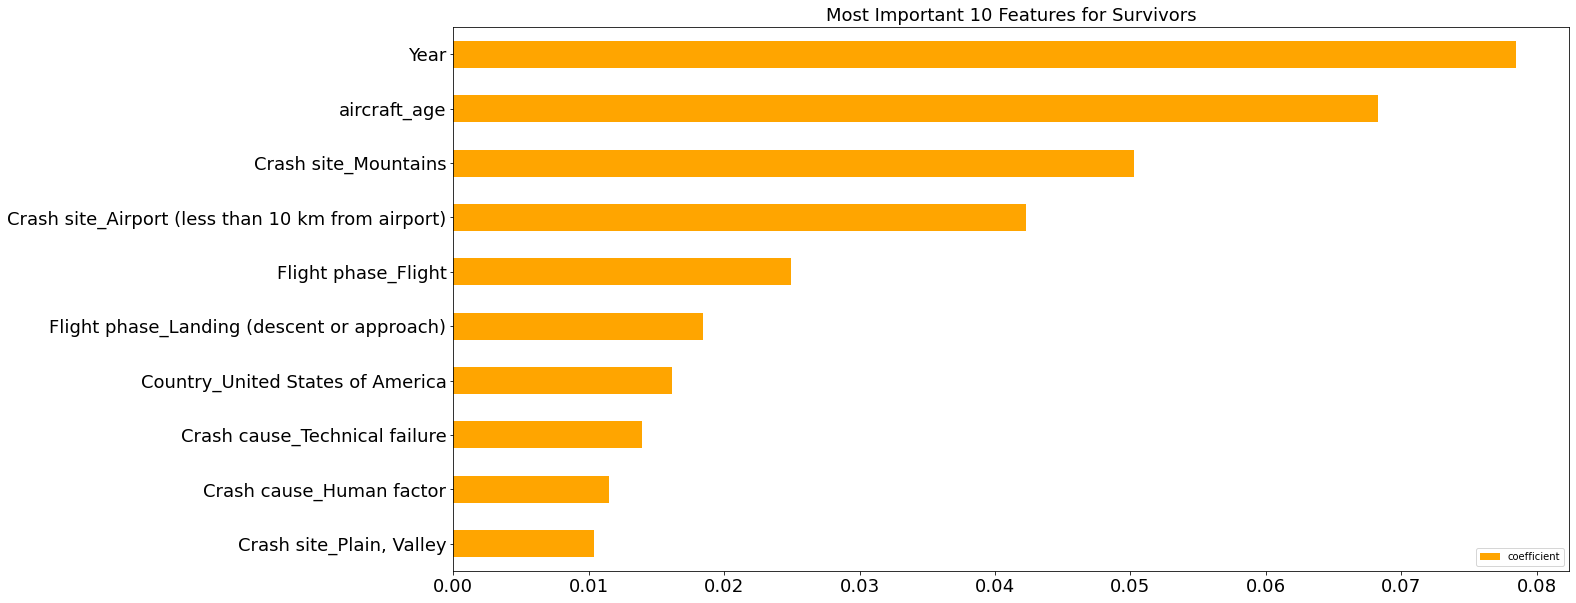

In [305]:
coef.sort_values(by = 'coefficient').tail(10).plot(kind = 'barh', figsize = (20, 10), color = 'orange',fontsize = 18)
plt.title('Most Important 10 Features for Survivors', fontsize = 18);
plt.savefig('image/feature_importance_most10.jpg')

In [186]:
pipe3.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'randomforestclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__max_samples', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_samples_leaf', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__min_weight_fraction_leaf', 'randomforestclassifier__n_estimators', 'randomforestclassifier__n_jobs', 'randomforestclassifier__oob_score', 'randomforestclassifier__random_state', 'randomforestclassifier__verbose', 'randomforestclassifier__warm_start'])

In [187]:
param_grid3 = {
    'randomforestclassifier__n_estimators': [100, 150, 200], 
    'randomforestclassifier__max_depth': [5, 10, 15], 
    'randomforestclassifier__min_samples_split': [2, 5, 7]
             }
gs3 = GridSearchCV(pipe3, param_grid = param_grid3, n_jobs = -1)

In [192]:
gs3.fit(X_train_enc, y_train)

/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': [5, 10, 15],
                         'randomforestclassifier__min_samples_split': [2, 5, 7],
                         'randomforestclassifier__n_estimators': [100, 150,
                                                                  200]})

In [193]:
gs3.best_params_

{'randomforestclassifier__max_depth': 15,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 150}

In [194]:
gs3.score(X_train_enc, y_train), gs3.score(X_test_enc, y_test)

(0.7142689371697005, 0.6946107784431138)

In [195]:
cross_val_score(gs3.best_estimator_, X_test_enc, y_test).mean()

0.6949660928534167

In [196]:
precision_score(y_train, gs3.predict(X_train_enc)), precision_score(y_test, gs3.predict(X_test_enc))

(0.6956806282722513, 0.6822936846183649)

#### 3.3.4. Neual Network

In [287]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras

In [274]:
ss = StandardScaler()

In [277]:
X_train_ss = ss.fit_transform(X_train_enc)
X_train_ss = pd.DataFrame(X_train_ss, columns = ss.get_feature_names_out())

In [278]:
X_test_ss = ss.transform(X_test_enc)
X_test_ss = pd.DataFrame(X_test_ss, columns = ss.get_feature_names_out())

In [279]:
X_train_ss.shape, X_test_ss.shape

((8515, 4473), (2839, 4473))

In [291]:
model = Sequential()
model.add(Dense(80, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(40, activation ='relu'))
model.add(Dropout(0.2))
model.add(Dense(20, activation ='relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [292]:
model.compile(
    optimizer = "adam", 
    loss = "binary_crossentropy", 
    metrics = "accuracy"
)

In [294]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 1)

In [296]:
history = model.fit(
    X_train_ss, y_train, 
    validation_data = (X_test_ss, y_test), epochs = 50, batch_size = None, callbacks = [early_stop])

Epoch 1/50
267/267 [==============================] - 2s 6ms/step - loss: 0.1680 - accuracy: 0.9180 - val_loss: 1.4277 - val_accuracy: 0.6862
Epoch 2/50
267/267 [==============================] - 1s 5ms/step - loss: 0.1617 - accuracy: 0.9207 - val_loss: 1.3510 - val_accuracy: 0.6918
Epoch 3/50
267/267 [==============================] - 1s 5ms/step - loss: 0.1492 - accuracy: 0.9231 - val_loss: 1.5475 - val_accuracy: 0.6788
Epoch 4/50
267/267 [==============================] - 1s 5ms/step - loss: 0.1442 - accuracy: 0.9271 - val_loss: 1.6173 - val_accuracy: 0.6777
Epoch 5/50
267/267 [==============================] - 1s 5ms/step - loss: 0.1321 - accuracy: 0.9332 - val_loss: 1.7959 - val_accuracy: 0.6756
Epoch 6/50
267/267 [==============================] - 1s 5ms/step - loss: 0.1304 - accuracy: 0.9340 - val_loss: 1.9054 - val_accuracy: 0.6703
Epoch 7/50
267/267 [==============================] - 1s 5ms/step - loss: 0.1248 - accuracy: 0.9386 - val_loss: 1.9344 - val_accuracy: 0.6608
Epoch 

## NLP

In [310]:
df_comm_nlp = df_comm

In [311]:
df_comm_nlp.isna().sum()

Date                  0
Time               4410
Aircraft              0
Operator              0
Flight phase        129
Flight type           0
Survivors             0
Crash site           30
Crash location        5
Country               0
Region                0
Circumstances         1
Crash cause           0
aircraft_age        590
people_on_board       0
fatal_on_board        0
num_survivor          0
manufacturer        218
Year                  0
dtype: int64

In [312]:
df_comm_nlp = df_comm_nlp.dropna(subset = ['Circumstances'])

In [314]:
NLP_X = df_comm_nlp['Circumstances']
NLP_y = df_comm_nlp['Survivors']

nX_train, nX_test, ny_train, ny_test = train_test_split(NLP_X, NLP_y, random_state = 42, stratify = NLP_y)

In [316]:
pipe_nlp = make_pipeline(CountVectorizer(stop_words = 'english'), LogisticRegression(max_iter = 10000))

In [317]:
pipe_nlp.fit(nX_train, ny_train)

Pipeline(steps=[('countvectorizer', CountVectorizer(stop_words='english')),
                ('logisticregression', LogisticRegression(max_iter=10000))])

In [318]:
pipe_nlp.score(nX_train, ny_train), pipe_nlp.score(nX_test, ny_test)

(0.9967112990368804, 0.94786896794646)

In [319]:
cross_val_score(pipe_nlp, nX_train, ny_train).mean()

0.9398637780980961

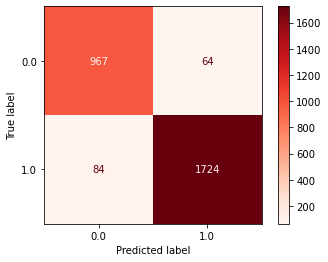

In [320]:
ConfusionMatrixDisplay.from_estimator(pipe_nlp, nX_test, ny_test, cmap = 'Reds');

In [321]:
accuracy_score(ny_test, pipe_nlp.predict(nX_test))

0.94786896794646

In [329]:
precision_score(y_test, pipe_nlp.predict(nX_test))

0.9642058165548099

In [322]:
nlp_coef = pd.DataFrame(pipe_nlp.named_steps['logisticregression'].coef_, 
             columns = pipe_nlp.named_steps['countvectorizer'].get_feature_names_out()).T.sort_values(by = 0)

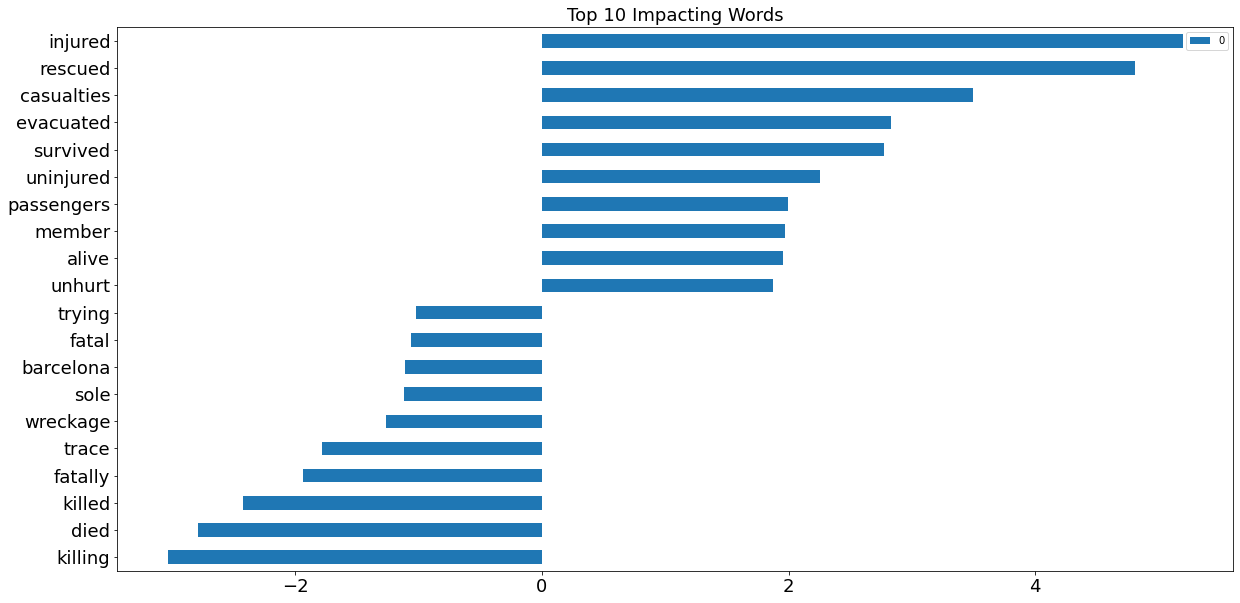

In [327]:
pd.concat([nlp_coef.head(10), nlp_coef.tail(10)]).plot(kind = 'barh', figsize = (20, 10), fontsize = 18);
plt.title('Top 10 Impacting Words', fontsize = 18);
plt.savefig('image/nlp.jpg')

In [193]:
cv = CountVectorizer(stop_words = 'english')

In [194]:
nX_train_cv = cv.fit_transform(nX_train)

In [195]:
df_text = pd.DataFrame(nX_train_cv.A, columns = cv.get_feature_names_out())

In [196]:
df_text.sum().sort_values(ascending = False)

aircraft      16667
flight         9350
crew           7704
runway         7144
pilot          7024
              ...  
mapping           1
maps              1
aykal             1
maquinista        1
beïda             1
Length: 29235, dtype: int64